In [1]:
import os
os.chdir('../')

import torch
from torch.functional import F
import numpy as np
from einops.layers.torch import Rearrange
from torchvision.transforms import Compose

# !pip install grad-cam
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

from src.opts.opts import parser
from src.models.model import VideoModel
from src.dataset.video_dataset import VideoDataset, prepare_clips_data
from src.dataset.utils import fgaid_to_fganame
from src.dataset.video_transforms import GroupMultiScaleCrop, Stack, ToTorchFormatTensor, GroupNormalize
from src.utils.reproducibility import make_reproducible

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

In [2]:
make_reproducible(0)

Making reproducible on seed 0


In [3]:
id_to_action_name_dict = fgaid_to_fganame(
    fga_map_file="/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt"
)

# Define model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# TSN

model_TSN = VideoModel(
    num_classes=1887, 
    num_segments=16, 
    base_model="InceptionV3",
    fusion_mode="TSN",
    verbose=False,
    pretrained="SS1",
    mode="validation"
    # mode="train",
).to(device)

checkpoint_TSN = torch.load(
    f='checkpoints/TSN_InceptionV3_SS1_bs32_ns16_ep15.pth', 
    map_location=torch.device(device)
)
model_TSN.load_state_dict(state_dict=checkpoint_TSN['model_state_dict'], strict=True)
model_TSN.eval();

=> Using SS1 weights
=> Using TSN fusion


In [6]:
# TSM

model_TSM = VideoModel(
    num_classes=1887, 
    num_segments=16, 
    base_model="InceptionV3",
    fusion_mode="TSM",
    verbose=False,
    pretrained="SS1",
    mode="validation"
    # mode="train",
).to(device)

checkpoint_TSM = torch.load(
    f='checkpoints/TSM_InceptionV3_SS1_bs32_ns16_ep15.pth', 
    map_location=torch.device(device)
)
model_TSM.load_state_dict(state_dict=checkpoint_TSM['model_state_dict'], strict=True)
model_TSM.eval();

=> Using SS1 weights
=> Using TSM fusion
No. of TSM modules = 11


In [7]:
# model_TSN(torch.rand(1,48,400,400))

In [8]:
# GSM

model_GSM = VideoModel(
    num_classes=1887, 
    num_segments=16, 
    base_model="InceptionV3",
    fusion_mode="GSM",
    verbose=False,
    pretrained="SS1",
    mode="validation",
    # mode="train",
).to(device)

checkpoint_GSM = torch.load(
    f='checkpoints/GSM_InceptionV3_SS1_bs32_ns16_ep15.pth', 
    map_location=torch.device(device)
)
model_GSM.load_state_dict(state_dict=checkpoint_GSM['model_state_dict'], strict=True)
model_GSM.eval();

=> Using SS1 weights
=> Using GSM fusion
No. of GSM modules = 11


In [9]:
# GSF

model_GSF = VideoModel(
    num_classes=1887, 
    num_segments=16, 
    base_model="InceptionV3",
    fusion_mode="GSF",
    verbose=False,
    pretrained="SS1",
    mode="validation"
    # mode="train"
).to(device)

checkpoint_GSF = torch.load(
    f='checkpoints/GSF_InceptionV3_SS1_bs32_ns16_ep15.pth', 
    map_location=torch.device(device)
)
model_GSF.load_state_dict(state_dict=checkpoint_GSF['model_state_dict'], strict=True)
model_GSF.eval();

=> Using SS1 weights
=> Using GSF fusion
No. of GSF modules = 11


# Dataset

In [10]:
video_name_arr, start_arr, end_arr, label_arr = prepare_clips_data(
    raw_annotation_file="/Users/artemmerinov/data/holoassist/data-annotation-trainval-v1_1.json",
    holoassist_dir="/Users/artemmerinov/data/holoassist/HoloAssist", 
    split_dir="/Users/artemmerinov/data/holoassist/data-splits-v1_2",
    fga_map_file="/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt",
    mode="validation",
    # mode="train",
    task="action",
)

transform = Compose([
    GroupMultiScaleCrop(input_size=299, scales=[1, .875]),
    Stack(roll=False),
    ToTorchFormatTensor(div=True),
    GroupNormalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = VideoDataset(
    holoassist_dir="/Users/artemmerinov/data/holoassist/HoloAssist", 
    video_name_arr=video_name_arr,
    start_arr=start_arr,
    end_arr=end_arr,
    label_arr=label_arr,
    num_segments=16,
    transform=transform,
    mode="validation",
    # mode="train",
)

len(dataset)


There are 207 videos in the split list file. 
There are 22 videos downloaded and stored on the disk 
There are 193 videos that present in the list but are missing on the disk.


746

# Test model

    cam_comparison__z041-june-24-22-printer_small__open-copy_gate
    cam_comparison__z041-june-24-22-printer_small__close-copy_gate

    cam_comparison__z132-aug-12-22-printer_big__withdraw-ink_cartridge
    cam_comparison__z132-aug-12-22-printer_big__insert-ink_cartridge

open-copy_gate
torch.Size([16, 299, 299, 3])


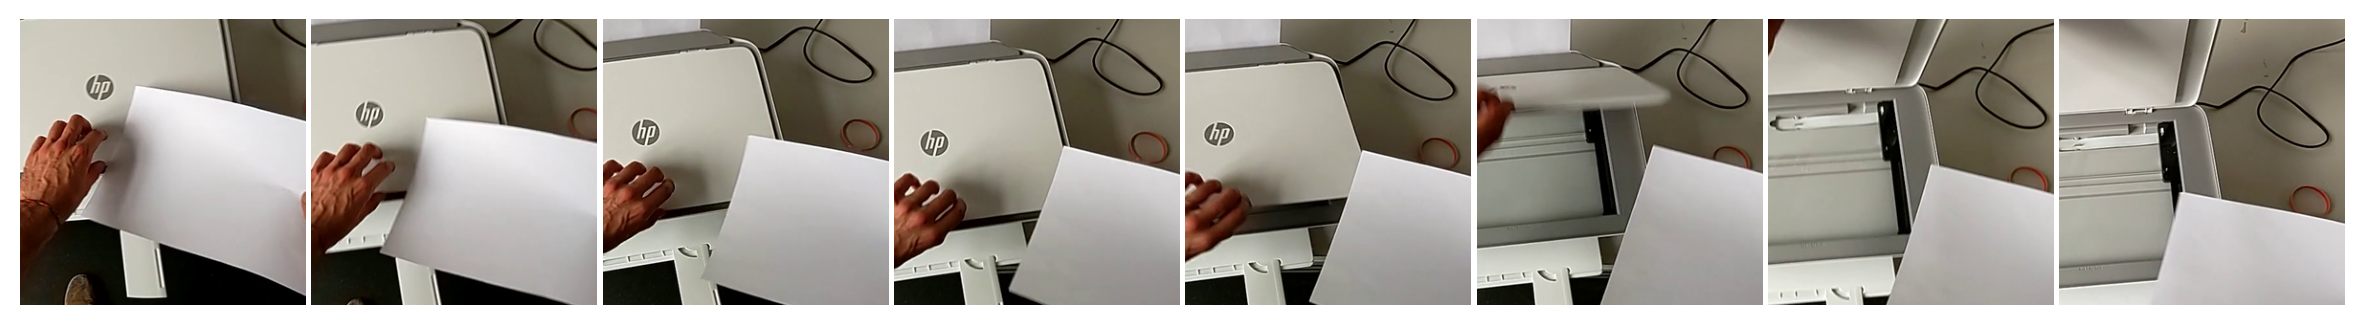

In [11]:
data, label = dataset[334]
print(id_to_action_name_dict[label])

rearranged_data = Rearrange("(t c) h w -> t h w c", t=16, c=3, h=299, w=299)(data)
print(rearranged_data.shape)

fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for ax, img in zip(axes, rearranged_data[::2]):
    img = img * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
    ax.imshow(img)
    ax.axis('off')
plt.subplots_adjust(wspace=0.02)
plt.show();

In [12]:
c_t, h, w = data.size()

# TSN
preds_TSN = F.softmax(model_TSN(data.view(1, c_t, h, w)), dim=1)
_, largest_ids_TSN = torch.topk(preds_TSN, k=5, dim=1, largest=True, sorted=True)
print([id_to_action_name_dict[i.item()] for i in largest_ids_TSN[0]])
print(torch.sort(preds_TSN, descending=True)[0][0].detach()[:5])
print()

# TSM
preds_TSM = F.softmax(model_TSM(data.view(1, c_t, h, w)), dim=1)
_, largest_ids_TSM = torch.topk(preds_TSM, k=5, dim=1, largest=True, sorted=True)
print([id_to_action_name_dict[i.item()] for i in largest_ids_TSM[0]])
print(torch.sort(preds_TSM, descending=True)[0][0].detach()[:5])
print()

# GSM
preds_GSM = F.softmax(model_GSM(data.view(1, c_t, h, w)), dim=1)
_, largest_ids_GSM = torch.topk(preds_GSM, k=5, dim=1, largest=True, sorted=True)
print([id_to_action_name_dict[i.item()] for i in largest_ids_GSM[0]])
print(torch.sort(preds_GSM, descending=True)[0][0].detach()[:5])
print()

# GSF
preds_GSF = F.softmax(model_GSF(data.view(1, c_t, h, w)), dim=1)
_, largest_ids_GSF = torch.topk(preds_GSF, k=5, dim=1, largest=True, sorted=True)


print([id_to_action_name_dict[i.item()] for i in largest_ids_GSF[0]])
print(torch.sort(preds_GSF, descending=True)[0][0].detach()[:5])
print()

['open-copy_gate', 'close-copy_gate', 'grab-paper_stack', 'place-paper_stack', 'grab-copy']
tensor([0.2512, 0.1351, 0.1081, 0.0936, 0.0732])

['open-copy_gate', 'close-copy_gate', 'grab-paper_stack', 'withdraw-paper_stack', 'lift-paper_stack']
tensor([0.7627, 0.1115, 0.0297, 0.0205, 0.0081])

['open-copy_gate', 'grab-paper_stack', 'withdraw-paper_stack', 'open-printer', 'grab-copy_gate']
tensor([0.8504, 0.0283, 0.0215, 0.0197, 0.0170])

['open-copy_gate', 'open-printer', 'grab-paper_stack', 'withdraw-paper_stack', 'grab-copy_gate']
tensor([0.8592, 0.0396, 0.0251, 0.0239, 0.0103])



# CAM

In [13]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM

In [14]:
cam_TSN = GradCAMPlusPlus(
    model=model_TSN, 
    target_layers=[model_TSN.base_model.mixed_10_tower_2_conv]
)
cam_TSM = GradCAMPlusPlus(
    model=model_TSM, 
    target_layers=[model_TSM.base_model.mixed_10_tower_2_conv]
)
cam_GSM = GradCAMPlusPlus(
    model=model_GSM, 
    target_layers=[model_GSM.base_model.mixed_10_tower_2_conv]
)
cam_GSF = GradCAMPlusPlus(
    model=model_GSF, 
    target_layers=[model_GSF.base_model.mixed_10_tower_2_conv]
)

targets = [ClassifierOutputTarget(label+1)]
grayscale_cams_TSN = cam_TSN(input_tensor=data.view(1, c_t, h, w), targets=targets)
grayscale_cams_TSM = cam_TSM(input_tensor=data.view(1, c_t, h, w), targets=targets)
grayscale_cams_GSM = cam_GSM(input_tensor=data.view(1, c_t, h, w), targets=targets)
grayscale_cams_GSF = cam_GSF(input_tensor=data.view(1, c_t, h, w), targets=targets)

In [15]:
images = []
cam_images_TSN = []
cam_images_TSM = []
cam_images_GSM = []
cam_images_GSF = []

for segment in range(16):
    img = rearranged_data[segment]
    img = img * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5]) # inverse norm
    cam_image_TSN = show_cam_on_image(
        img=np.array(img), 
        mask=grayscale_cams_TSN[segment], 
        use_rgb=True, 
        image_weight=0.6
    )
    cam_image_TSM = show_cam_on_image(
        img=np.array(img), 
        mask=grayscale_cams_TSM[segment], 
        use_rgb=True, 
        image_weight=0.6
    )
    cam_image_GSM = show_cam_on_image(
        img=np.array(img), 
        mask=grayscale_cams_GSM[segment], 
        use_rgb=True, 
        image_weight=0.6
    )
    cam_image_GSF = show_cam_on_image(
        img=np.array(img), 
        mask=grayscale_cams_GSF[segment], 
        use_rgb=True, 
        image_weight=0.6
    )
    images.append(img)
    cam_images_TSN.append(cam_image_TSN)
    cam_images_TSM.append(cam_image_TSM)
    cam_images_GSM.append(cam_image_GSM)
    cam_images_GSF.append(cam_image_GSF)

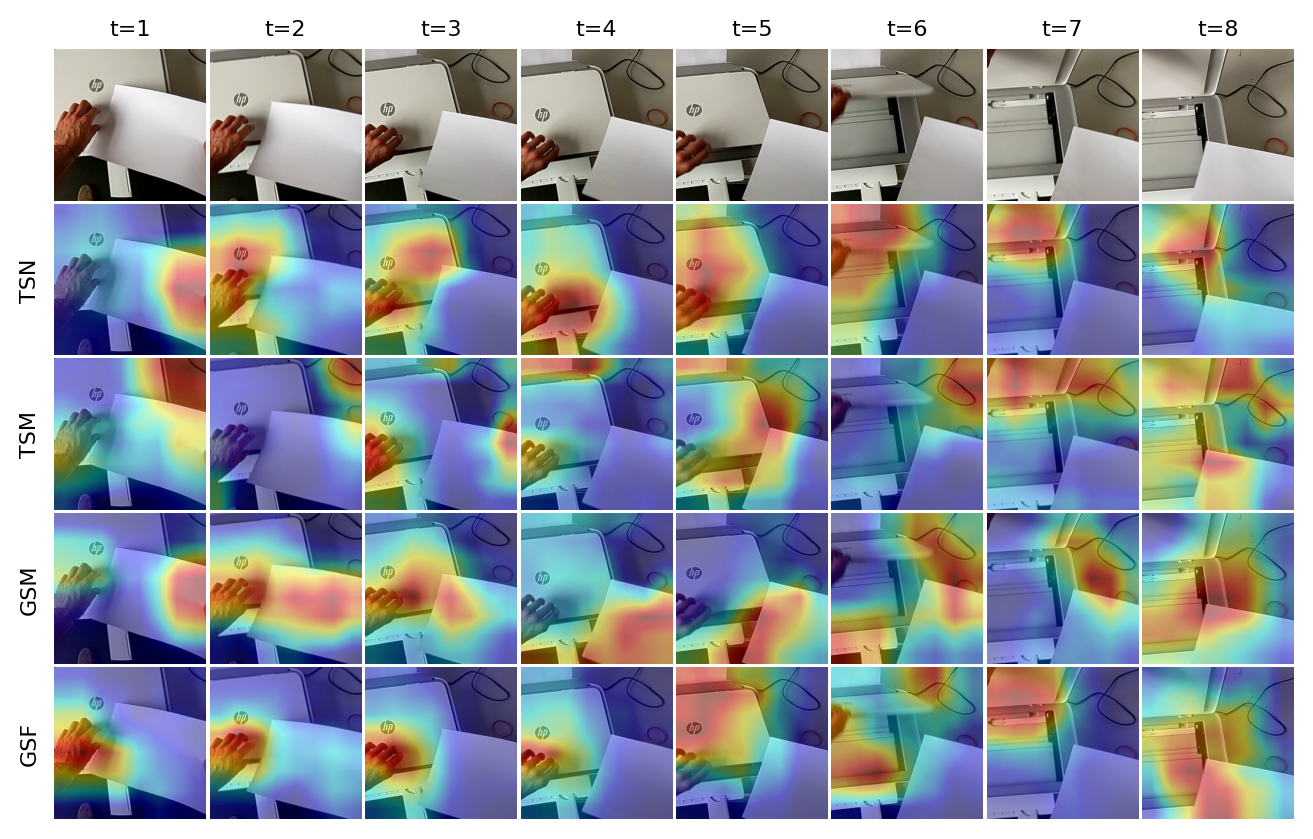

In [16]:
fig, axes = plt.subplots(5, 8, figsize=(8,5))

for ax, img in zip(axes[0], images[::2]):
    ax.imshow(img)
    ax.axis('off')

for ax, img in zip(axes[1], cam_images_TSN[::2]):
    ax.imshow(img)
    ax.axis('off')

for ax, img in zip(axes[2], cam_images_TSM[::2]):
    ax.imshow(img)
    ax.axis('off')

for ax, img in zip(axes[3], cam_images_GSM[::2]):
    ax.imshow(img)
    ax.axis('off')

for ax, img in zip(axes[4], cam_images_GSF[::2]):
    ax.imshow(img)
    ax.axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.02)

# Add labels on the left side of the figure, centered in each row
y_positions = [ax.get_position().y0 + ax.get_position().height / 2 for ax in axes[:, 0]]
for y, label in zip(y_positions, ['', 'TSN', 'TSM', 'GSM', 'GSF']):
    fig.text(0.11, y, label, va='center', ha='center', fontsize=8, rotation=90)

# Add horizontal labels on the top of the figure for column numbers
x_positions = [ax.get_position().x0 + ax.get_position().width / 2 for ax in axes[0, :]]
for x, col_num in zip(x_positions, range(1,9)):
    fig.text(x, 0.90, f"t={col_num}", va='center', ha='center', fontsize=8, rotation=0)

plt.show()